In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
from tensorflow.keras.datasets import cifar100

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow import keras

In [ ]:
from tensorflow.keras import optimizers, models, layers

In [ ]:
(X_nontest, y_nontest), (X_test, y_test) = cifar100.load_data()

# Parse numbers as floats
X_nontest = X_nontest.astype('float32')
X_test = X_test.astype('float32')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [ ]:
indices = np.random.permutation(X_nontest.shape[0])
training_idx, val_idx = indices[:40000], indices[40000:]
X_train, y_train = X_nontest[training_idx,:], y_nontest[training_idx]
X_val, y_val = X_nontest[val_idx,:], y_nontest[val_idx]

In [ ]:
print(f'Training set size: {X_train.shape}')
print(f'Training label size: {y_train.shape}')
print(f'Validation set size: {X_val.shape}')
print(f'Validation label size: {y_val.shape}')
print(f'Test set size: {X_test.shape}')
print(f'Test label size: {y_test.shape}')

Training set size: (40000, 32, 32, 3)
Training label size: (40000, 1)
Validation set size: (10000, 32, 32, 3)
Validation label size: (10000, 1)
Test set size: (10000, 32, 32, 3)
Test label size: (10000, 1)


In [ ]:
X_train = (X_train)/255
X_val = (X_val)/255
X_test = (X_test)/255

nb_classes = len(np.unique(y_nontest))
print(nb_classes)
img_width, img_height, img_num_channels = 32, 32, 3
input_shape = (img_width, img_height, img_num_channels)

y_train = to_categorical(y_train, nb_classes)
y_val = to_categorical(y_val, nb_classes)
y_test = to_categorical(y_test, len(np.unique(y_test)))

100


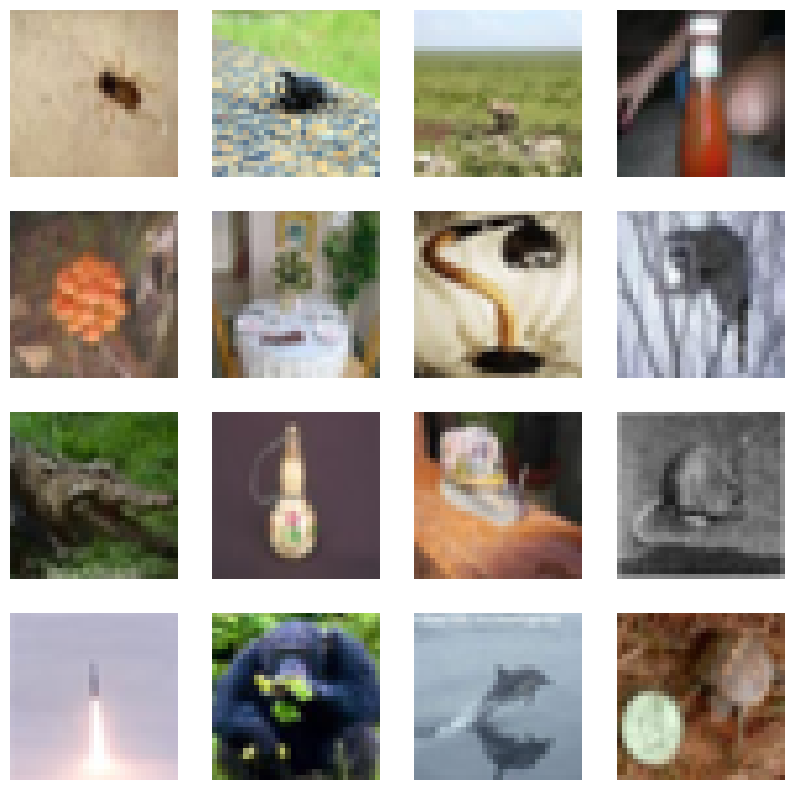

In [ ]:
plt.figure(figsize=(10, 10))

for i in range (4*4):
  plt.subplot(4, 4, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')

plt.show()

# Hyperparameter Plots

In [ ]:
def create_cnn(dropout_rate=0.25, num_layers=2):
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Variable blocks
    for i in range(1, num_layers + 1):
        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation('elu'))
        model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
        model.add(Activation('elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))

    # Dense Block (Fixed)
    model.add(Flatten())
    model.add(Dense(32 * (2 ** (i + 1))))
    model.add(Activation('elu'))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(nb_classes, activation='softmax'))
    return model

def run_experiment(param_name, param_values, runs_per_param=3):
    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)

    histories = []
    for val in param_values:
        print(f"Running {param_name}: {val}")
        run_histories = []
        test_accuracies = []
        for run in range(runs_per_param):
            print(f"  Run {run + 1}/{runs_per_param}")
            # Create new model each time
            if param_name == 'learning_rate':
                model = create_cnn()
                optimizer = optimizers.Adam(learning_rate=val, decay=1e-6)
            elif param_name == 'dropout_rate':
                model = create_cnn(dropout_rate=val)
                optimizer = optimizers.Adam(learning_rate=0.0001, decay=1e-6)
            elif param_name == 'num_cnn_blocks':
                model = create_cnn(num_layers=val)
                optimizer = optimizers.Adam(learning_rate=0.0001, decay=1e-6)
            else:
                raise ValueError("Unknown parameter!")

            model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=8, restore_best_weights=True)

            history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                                validation_data=(X_val, y_val),
                                epochs=20,
                                verbose=1,
                                callbacks=[early_stop])
            run_histories.append(history)
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
            test_accuracies.append(test_accuracy)
            print(f"    Test Accuracy Run {run + 1}: {test_accuracy:.4f}")
        avg_test_accuracy = np.mean(test_accuracies)
        print(f"Average Test Accuracy for {param_name}={val}: {avg_test_accuracy:.4f}\n")
        histories.append((val, run_histories))
    return histories

In [ ]:
def plot_histories_with_std(histories, param_name):
    def extract_metric(run_histories, metric):
        return [np.interp(np.arange(max_len), np.arange(len(h.history[metric])), h.history[metric]) for h in run_histories]

    plt.figure(figsize=(14, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    for val, run_histories in histories:
        print(histories)
        # Ensure all histories are aligned (pad shorter runs)
        max_len = max(len(h.history['loss']) for h in run_histories)
        losses = np.array(extract_metric(run_histories, 'loss'))
        val_losses = np.array(extract_metric(run_histories, 'val_loss'))

        mean_loss = np.mean(losses, axis=0)
        std_loss = np.std(losses, axis=0)
        mean_val_loss = np.mean(val_losses, axis=0)
        std_val_loss = np.std(val_losses, axis=0)

        epochs = np.arange(max_len)
        plt.plot(epochs, mean_loss, label=f"Train Loss - {param_name}: {val}")
        plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

        plt.plot(epochs, mean_val_loss, '--', label=f"Val Loss - {param_name}: {val}")
        plt.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.2)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss vs Epoch ({param_name})")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for val, run_histories in histories:
        max_len = max(len(h.history['accuracy']) for h in run_histories)
        accs = np.array(extract_metric(run_histories, 'accuracy'))
        val_accs = np.array(extract_metric(run_histories, 'val_accuracy'))

        mean_acc = np.mean(accs, axis=0)
        std_acc = np.std(accs, axis=0)
        mean_val_acc = np.mean(val_accs, axis=0)
        std_val_acc = np.std(val_accs, axis=0)

        epochs = np.arange(max_len)
        plt.plot(epochs, mean_acc, label=f"Train Acc - {param_name}: {val}")
        plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2)

        plt.plot(epochs, mean_val_acc, '--', label=f"Val Acc - {param_name}: {val}")
        plt.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.2)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy vs Epoch ({param_name})")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Running num_cnn_blocks: 1
  Run 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.0400 - loss: 4.4109 - val_accuracy: 0.1368 - val_loss: 3.8208
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.1137 - loss: 3.8831 - val_accuracy: 0.1730 - val_loss: 3.5854
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.1428 - loss: 3.6825 - val_accuracy: 0.2067 - val_loss: 3.4074
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.1673 - loss: 3.5603 - val_accuracy: 0.2233 - val_loss: 3.2933
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.1875 - loss: 3.4522 - val_accuracy: 0.2387 - val_loss: 3.2294
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.1958 - loss: 3.3773 - val_accuracy: 0.2580 - val_loss: 3.1112
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.2103 - loss: 3.3068 - val_accuracy: 0.2635 - val_loss: 3.0571
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.2214 - loss: 3.2396 - val_accurac

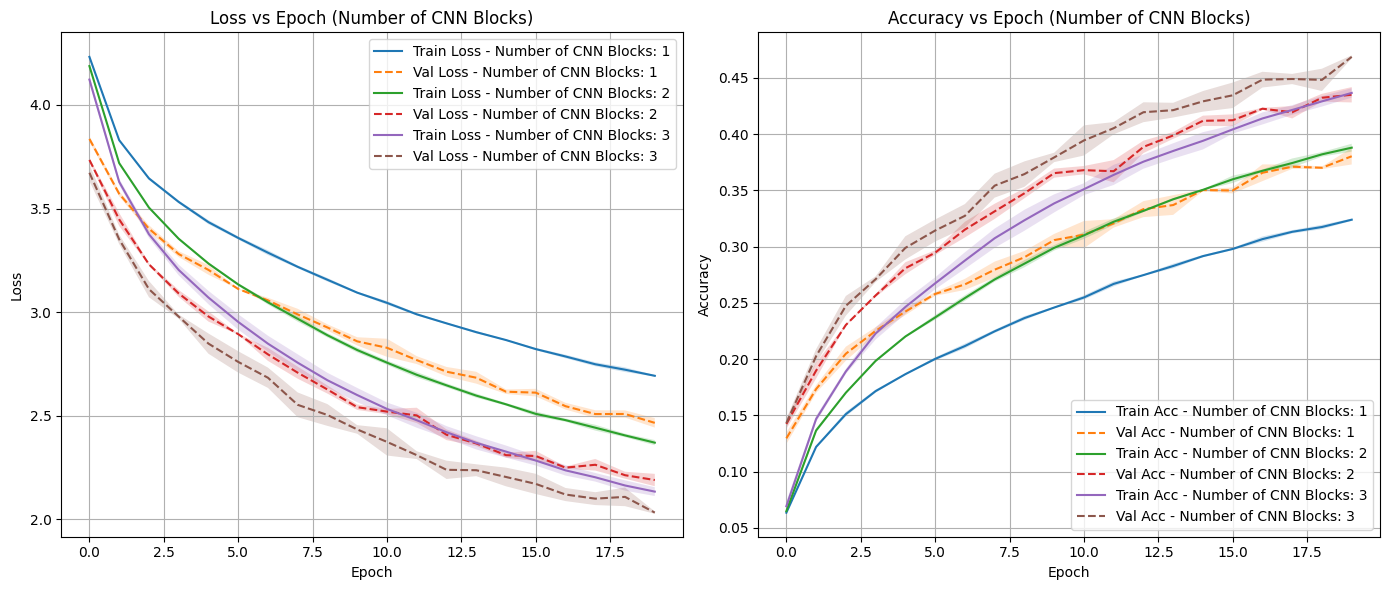

In [ ]:
if __name__ == "__main__":
    # Experiment 1: Learning Rate
    # learning_rates = [1e-3, 1e-4, 1e-5]
    # lr_histories = run_experiment('learning_rate', learning_rates)
    # plot_histories_with_std(lr_histories, 'Learning Rate')

    # # Experiment 2: Dropout Rate
    # dropout_rates = [0.25, 0.3, 0.5]
    # dropout_histories = run_experiment('dropout_rate', dropout_rates)
    # plot_histories_with_std(dropout_histories, 'Dropout Rate')

    # Experiment 3: Number of CNN blocks
    num_layers_list =  [1, 2, 3]
    layers_histories = run_experiment('num_cnn_blocks', num_layers_list)
    plot_histories_with_std(layers_histories, 'Number of CNN Blocks')

# CNN Model

In [ ]:
num_layers = 3
dropout_rate = 0.3

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Variable blocks
for i in range(1, num_layers + 1):
    model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(32 * (2 ** i), (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

# Dense Block (Fixed)
model.add(Flatten())
model.add(Dense(32 * (2 ** (i + 1))))
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))

# Output Layer
model.add(Dense(nb_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,748,356 (6.67 MB)

 Trainable params: 1,748,356 (6.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate = 0.0001, decay = 1e-6), metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,
            fill_mode='nearest')  # randomly flip images
datagen.fit(X_train)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights = True)

# Fit data to model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                   epochs=20,
                   validation_data=(X_val, y_val),
                   verbose=1,
                   callbacks=[early_stop])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.0347 - loss: 4.3890 - val_accuracy: 0.1224 - val_loss: 3.8052
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.1181 - loss: 3.7770 - val_accuracy: 0.2012 - val_loss: 3.3854
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.1672 - loss: 3.5046 - val_accuracy: 0.2260 - val_loss: 3.2075
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.2025 - loss: 3.3049 - val_accuracy: 0.2421 - val_loss: 3.0791
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.2211 - loss: 3.1873 - val_accuracy: 0.2635 - val_loss: 2.9793
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.2448 - loss: 3.0724 - val_accuracy: 0.3062 - val_loss: 2.8045
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.2714 - loss: 2.9565 - val_accuracy: 0.3303 - val_loss: 2.6868
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.2808 - loss: 2.8795 - val_accurac

In [ ]:
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)


    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.figure()
    plt.show()

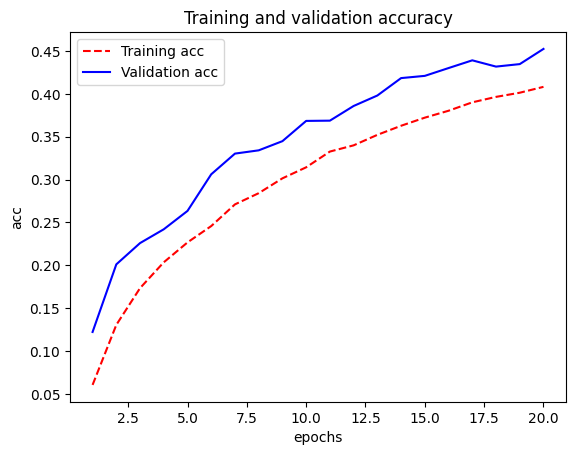

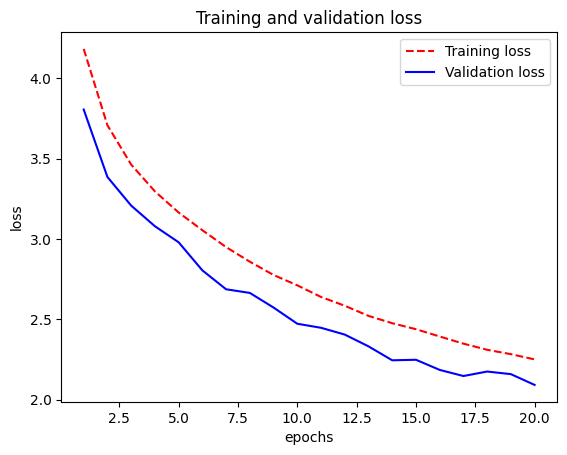

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_history(history)

In [ ]:
model_evaluate_test = model.evaluate(X_test, y_test)
model_evaluate_test[1]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4510 - loss: 2.0610


0.44999998807907104